<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Part 2: <strong>Neural Network Modeling</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>of time series</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Análise de Séries Temporais e Previsão 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

In [1]:
import logging

In [2]:
# Desativa mensagem constante dos dispositivos disponíveis para treino de modelos
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, smape, rmse, r2_score
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import seaborn as sns

In [8]:
import optuna

In [9]:
# Inicializa ficheiro de armazenamento de trials do Optuna
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

# Inicialização das Séries

In [10]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [11]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [12]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [13]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [14]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [15]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [16]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [17]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 784
2 Residential Property Prices for United Kingdom 227
3 Gross Domestic Product for United Kingdom 280
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 843
5 UK_Daily_Policy_Data 8886


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

Escolha da série temporal a modelar:

In [19]:
series_chosen = 0
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

Escolha das métricas a avaliar, incluindo seleção de uma principal para otimização de hiperparâmetros.

In [20]:
metrics = [smape, r2_score]
main_metric = metrics[0]
assert main_metric in metrics

In [21]:
splitting = 0.9
visualizing = 0.7

In [22]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

Scaling das séries temporais para treino das redes neuronais.

In [23]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [24]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

# Modelação de Time Series com Redes Neuronais

O pacote *darts* possibilita o uso de várias arquiteturas de redes neuronais para modelação de séries temporais. Para a construção e treino das redes, utiliza como backend o pacote pytorch-lightning, um framework para pytorch.

Utilizamos uma GPU para treinar os nossos modelos localmente. 

In [25]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [26]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [27]:
# Criacao de um callback de logging dos losses de treino e validacao
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [28]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.00001 (`min_delta`) 
# over a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [29]:
from darts.models import RNNModel, BlockRNNModel

### Treino de LSTM

Construção da primeira rede neuronal com hiperparâmetros default.

In [30]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=int(len(val)/2),     # Estes hiperparametros sao um fator da dimensao da serie a ser modelada
    input_chunk_length=int(len(val)/4),  # para garantir inputs de dimensao adequada
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [31]:
# Treino do modelo com validacao
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023163DB9F30>, <__main__.LossRecorder object at 0x0000023163DBA020>]})

O modelo apresenta uma aprendizagem adequada ao longo das épocas de treino.

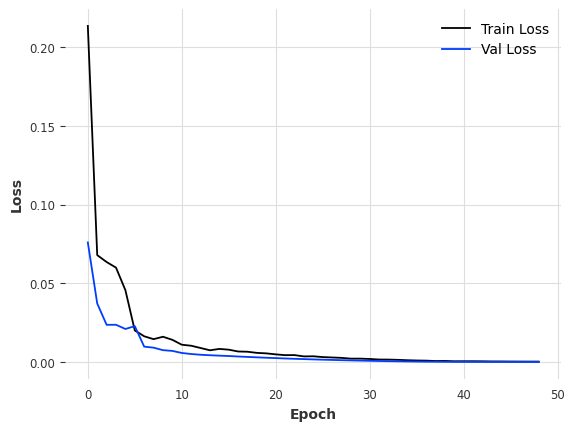

In [32]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023176BE0490>, <__main__.LossRecorder object at 0x0000023176BE07F0>]})

In [34]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

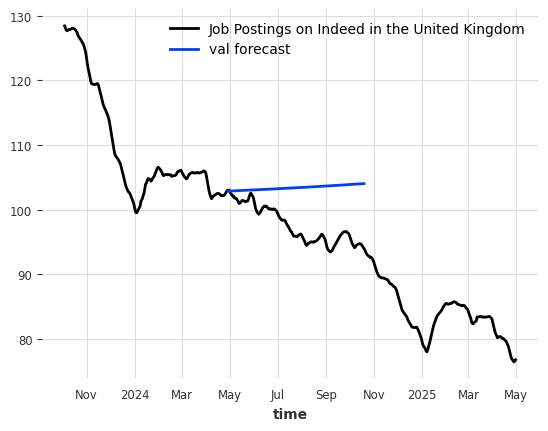

In [35]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

O modelo 

### Treino de NBEATS

Como experiência, treinamos também uma arquitetura de redes neuronais mais recente, mas não realizamos mais desenvolvimentos devido à complexidade de treino maior associado a esta arquitetura. 
Mais informações: https://arxiv.org/abs/1905.10437

In [36]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [37]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    batch_size=64,
    n_epochs=100, 
    random_state=7, 
    optimizer_kwargs={"lr": 1e-4},
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, batch_size=64, n_epochs=100, random_state=7, optimizer_kwargs={'lr': 0.0001}, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023176BE3C40>, <__main__.LossRecorder object at 0x0000023176BE39A0>]})

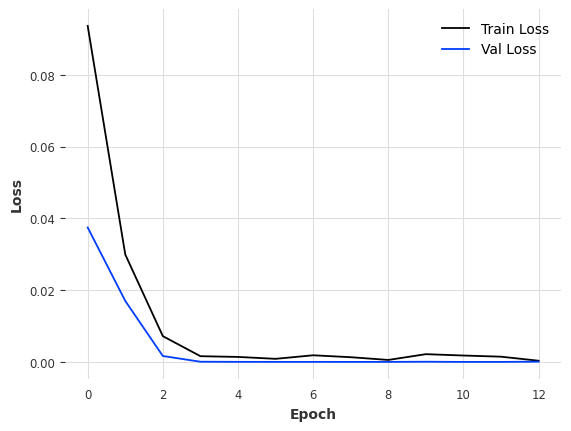

In [38]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
len(val)

174

In [40]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

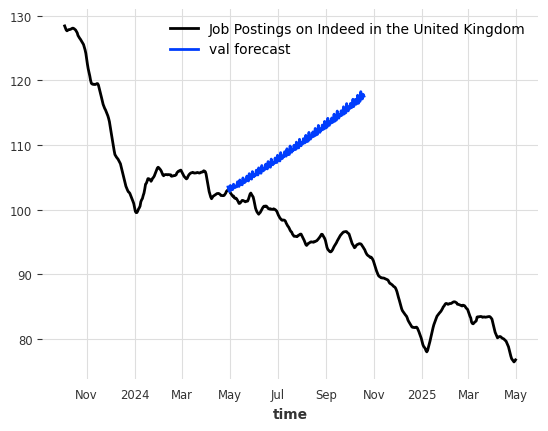

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="val forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [42]:
from darts.models import NaiveSeasonal

In [43]:
base_model = NaiveSeasonal(K=1)

In [44]:
base_model.model_name = "Baseline"

In [45]:
def backtest_models(
    series: TimeSeries, 
    models: list, 
    horizons: list=[1, 3, 7], 
    points_to_test: int=len(test), 
    verbose=True, retrain=False, baseline=base_model, metrics=metrics
):
    backtest_results = dict()
    if baseline:
        models = [baseline, *models]
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    transformer.transform(series),
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=retrain,
                    verbose=verbose,
                )
            backtest = transformer.inverse_transform(backtest)
            backtests.append(backtest)
        backtest_results[horizon] = {
            str(model.model_name): (backtests[i], {metric.__name__: round(metric(series, backtests[i]), 3) for metric in metrics}) 
            for i, model in enumerate(models)
        }
    return backtest_results

In [46]:
def plot_backtest_results(
    series: TimeSeries, 
    backtest_results: dict, 
    points_to_test: int=len(test),
):
    for horizon, model in backtest_results.items():
        plt.figure(figsize=(12, 6))
        series.drop_before(int(len(series) - 1.5*points_to_test)).plot(label='data')
        for model_name, (backtest, metrics) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, {metrics}')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.ylabel("Series value")
        plt.legend()
        plt.show()

In [47]:
models = [nbeats_model, lstm_model]

In [48]:
results = backtest_models(
    series, 
    models=models, 
    metrics=metrics,
    points_to_test=len(test)
)

Backtesting 1 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

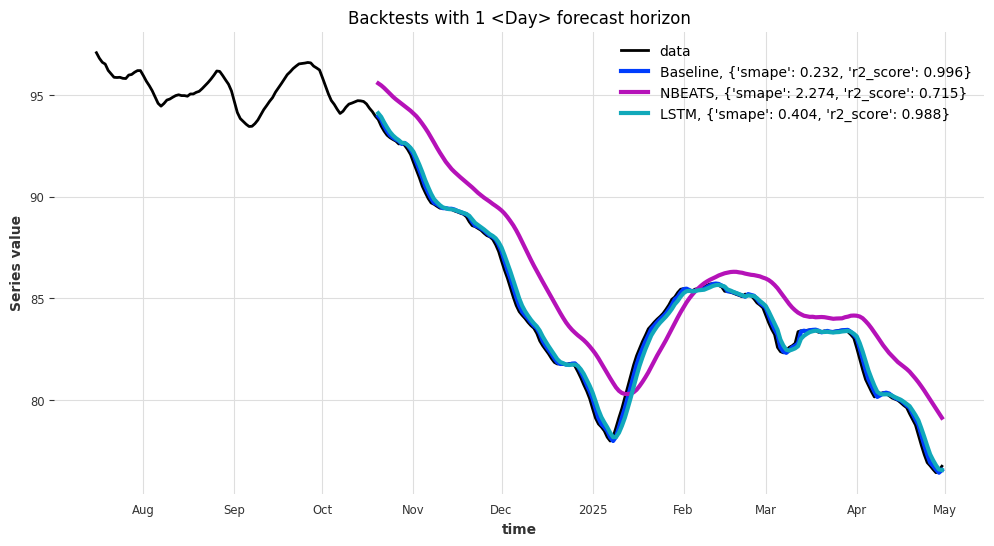

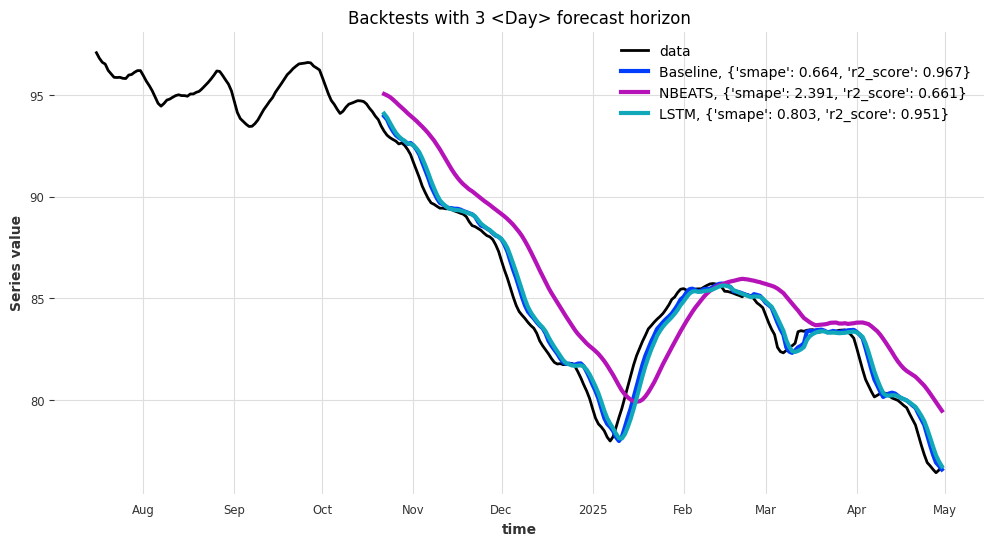

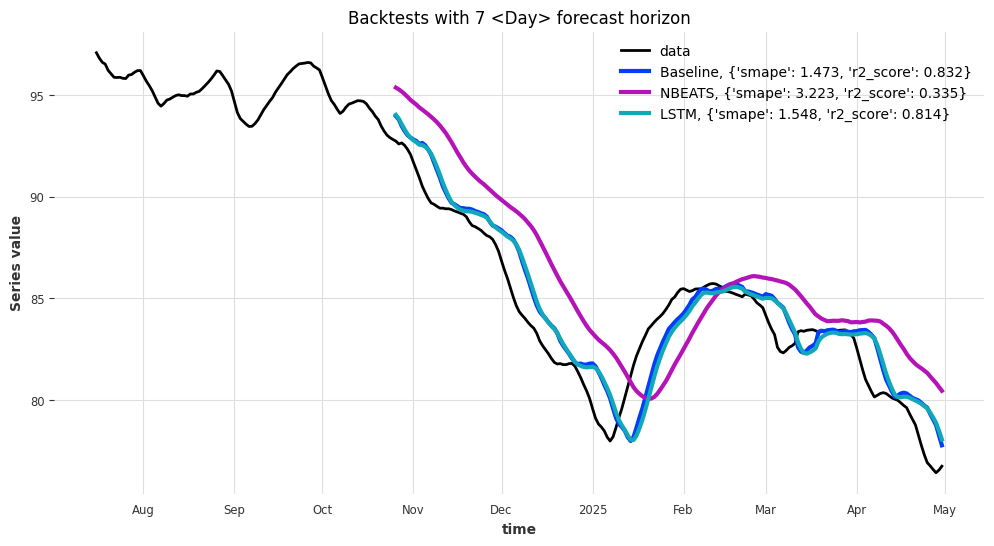

In [49]:
plot_backtest_results(series, results, points_to_test=len(test))

In [50]:
import optuna

In [51]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [52]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": trial.suggest_categorical("model", ["RNN", "GRU", "LSTM"]),
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "batch_size": 2 ** trial.suggest_int("log2(batch_size)", 4, 8),  # will be a power of two
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] != 1:
        params["dropout"] = trial.suggest_float("dropout", 0, 0.3)
        
    trial.set_user_attr("model_params", params)
    
    model = train_RNN(params)
    backtests = backtest_models(
        series[train.time_index.union(val.time_index)], 
        models=[model], 
        horizons=[1, 2, 3, 5, 7],
        metrics=metrics,
        points_to_test=len(val),
    )
    results = [model_dict[params["model"]][1][main_metric.__name__]/(horizon**0.5) 
               for horizon, model_dict in backtests.items()]
    
    return sum(results) / len(results)

In [53]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{main_metric.__name__}_avghorizons_RNNfamily_study",
    load_if_exists=True
)

[I 2025-05-24 20:58:51,869] Using an existing study with name 'Job_Postings_smape_avghorizons_RNNfamily_study' instead of creating a new one.


In [54]:
# Optimize for n_trials, using one thread, timeout of 5 min
study.optimize(optimize_RNN, n_trials=100, n_jobs=1)  # , timeout=30)

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:58:56,981] Trial 703 finished with value: 0.5711435790781486 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 5, 'learning_rate': 0.033978771725668086}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:02,026] Trial 704 finished with value: 0.32272046598821263 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.0516190397418218}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:07,454] Trial 705 finished with value: 0.3176164735604293 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.016256576752306167}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:12,609] Trial 706 finished with value: 0.33766022092303594 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.02778979418116233}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:17,654] Trial 707 finished with value: 0.5581786846497517 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 43, 'learning_rate': 0.02087611844123626}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:22,662] Trial 708 finished with value: 0.3709018907711901 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.03804361523906578}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:27,828] Trial 709 finished with value: 0.30297807043831765 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 27, 'learning_rate': 0.03212358500183484}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:32,883] Trial 710 finished with value: 0.3309573644724603 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.04865140832414271}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:38,207] Trial 711 finished with value: 0.31069093324436403 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 11, 'learning_rate': 0.025264102296786186}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:43,796] Trial 712 finished with value: 0.30399201698315303 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.03777755840828619}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:48,853] Trial 713 finished with value: 0.2883217576056577 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 21, 'learning_rate': 0.030595988087156998}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 20:59:55,878] Trial 714 finished with value: 0.3614610821427675 and parameters: {'model': 'GRU', 'hidden_dim': 47, 'n_rnn_layers': 5, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.020641219111088342, 'dropout': 0.003094903341082988}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:00,845] Trial 715 finished with value: 17.565023172205095 and parameters: {'model': 'RNN', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 25, 'learning_rate': 0.04433706542164454}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:07,222] Trial 716 finished with value: 3.6318079452217056 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 4, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.0261111767506298, 'dropout': 0.2748894210701625}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:12,807] Trial 717 finished with value: 1.9125385826255203 and parameters: {'model': 'LSTM', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03471579932586745}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:17,654] Trial 718 finished with value: 1.0385200831614478 and parameters: {'model': 'GRU', 'hidden_dim': 26, 'n_rnn_layers': 1, 'log2(batch_size)': 7, 'input_chunk_length': 41, 'learning_rate': 0.029614303973095484}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:22,637] Trial 719 finished with value: 0.2894447334359581 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.056265675691737}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:27,680] Trial 720 finished with value: 0.43701505932202594 and parameters: {'model': 'GRU', 'hidden_dim': 24, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.0030538144624249427}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:32,781] Trial 721 finished with value: 43.29732695907181 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 4.1465951603930695e-05}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:37,912] Trial 722 finished with value: 0.376759135124906 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 24, 'learning_rate': 0.040646443925315474}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:43,254] Trial 723 finished with value: 0.35203777636701017 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.018504478000033}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:48,264] Trial 724 finished with value: 0.35539040233643393 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.024172765541928723}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:53,092] Trial 725 finished with value: 1.154395366380706 and parameters: {'model': 'GRU', 'hidden_dim': 9, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.03364472274013234}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:00:58,232] Trial 726 finished with value: 0.35204584567999636 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.04400275367634764}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:03,343] Trial 727 finished with value: 0.3728690358373469 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.028405010787393607}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:08,752] Trial 728 finished with value: 0.3312612922213568 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.022343665282017783}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:14,230] Trial 729 finished with value: 0.4383588747829206 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.037593550692349535}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:19,238] Trial 730 finished with value: 0.27410121465587955 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.03327413143989702}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:24,295] Trial 731 finished with value: 0.38405301665736946 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.04673323903428295}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:29,473] Trial 732 finished with value: 0.28880246849674845 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.062042994304778935}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:34,486] Trial 733 finished with value: 0.29045264108685664 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 43, 'learning_rate': 0.03264554774005194}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:39,668] Trial 734 finished with value: 0.32297971104358214 and parameters: {'model': 'GRU', 'hidden_dim': 48, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.026731101836319708}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:45,104] Trial 735 finished with value: 0.6721770403173838 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.0384845700177549}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:50,282] Trial 736 finished with value: 0.2806074890299952 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.030395141986930555}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:01:55,439] Trial 737 finished with value: 1.1733464618475722 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.01946022074395148}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:00,465] Trial 738 finished with value: 3.318960731136811 and parameters: {'model': 'RNN', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.02555319482888868}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:05,662] Trial 739 finished with value: 0.3455629870292631 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.02895338671229806}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:11,245] Trial 740 finished with value: 1.4867807162109759 and parameters: {'model': 'LSTM', 'hidden_dim': 37, 'n_rnn_layers': 2, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.023447356051855734, 'dropout': 0.11269989770098765}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:16,685] Trial 741 finished with value: 0.496883453343535 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.016201641579866782}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:21,717] Trial 742 finished with value: 0.43372199364193725 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.03212263949977241}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:26,888] Trial 743 finished with value: 0.3769991703933134 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.04772787212993298}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:32,053] Trial 744 finished with value: 0.3514116660345402 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.0217134266084413}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:37,217] Trial 745 finished with value: 0.2891859171655121 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.03869253715594295}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:42,251] Trial 746 finished with value: 0.2914475692838482 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.028440503633046788}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:48,686] Trial 747 finished with value: 11.129190588035017 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.00017659641603579528}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:53,804] Trial 748 finished with value: 0.4593077414353643 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 16, 'learning_rate': 0.0746707906616134}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:02:58,905] Trial 749 finished with value: 0.4103275201489023 and parameters: {'model': 'GRU', 'hidden_dim': 49, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.0036826777118336928}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:03,951] Trial 750 finished with value: 0.33612472682096906 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.03398304659340167}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:09,074] Trial 751 finished with value: 0.5726677078892498 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.024512214072632914}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:14,262] Trial 752 finished with value: 1.127956484922946 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.05474969947763511}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:19,801] Trial 753 finished with value: 0.8515444300922663 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.04238506060186096}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:24,866] Trial 754 finished with value: 0.4102866402235673 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.005166875915634202}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:29,865] Trial 755 finished with value: 0.32707374423027447 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.030455251187251085}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:35,672] Trial 756 finished with value: 0.2914973041839106 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 5, 'input_chunk_length': 40, 'learning_rate': 0.018940541410799747}. Best is trial 399 with value: 0.2648762954237142.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:48,173] Trial 757 finished with value: 8.341271573280716 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 4, 'log2(batch_size)': 4, 'input_chunk_length': 40, 'learning_rate': 0.038205496426999, 'dropout': 0.07256081416815297}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:53,171] Trial 758 finished with value: 0.8352718010023359 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.0024905562956515975}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:03:58,245] Trial 759 finished with value: 0.36196982433292746 and parameters: {'model': 'GRU', 'hidden_dim': 43, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.026630666864281692}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:03,495] Trial 760 finished with value: 2.0025380207785637 and parameters: {'model': 'RNN', 'hidden_dim': 47, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.03306513812209584}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:08,608] Trial 761 finished with value: 0.6690305075975946 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 43, 'learning_rate': 0.022000392076333086}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:13,881] Trial 762 finished with value: 1.3265628093613162 and parameters: {'model': 'LSTM', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03751190812013931}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:19,089] Trial 763 finished with value: 0.34777621930520725 and parameters: {'model': 'GRU', 'hidden_dim': 44, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.047702726658421395}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:25,131] Trial 764 finished with value: 0.6011997621528906 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.0292122046311077, 'dropout': 0.0855798521844015}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:30,274] Trial 765 finished with value: 0.364299555131261 and parameters: {'model': 'GRU', 'hidden_dim': 46, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.02451327298735598}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:35,640] Trial 766 finished with value: 0.3019243872919714 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.04340344714858104}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:40,707] Trial 767 finished with value: 0.5609973068137373 and parameters: {'model': 'GRU', 'hidden_dim': 28, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.03462777854780945}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:45,669] Trial 768 finished with value: 0.327715391761369 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.016590281106611517}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:50,675] Trial 769 finished with value: 0.3766785544814125 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.028604763336503483}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:04:56,681] Trial 770 finished with value: 5.945001273934948 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 3, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.055244690343148266, 'dropout': 0.09178313926913896}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:01,878] Trial 771 finished with value: 0.6776648810888779 and parameters: {'model': 'GRU', 'hidden_dim': 50, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.022961372575997244}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:07,330] Trial 772 finished with value: 0.3110070209144988 and parameters: {'model': 'GRU', 'hidden_dim': 34, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 43, 'learning_rate': 0.032245434438929174}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:12,450] Trial 773 finished with value: 0.372326657768052 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.04167913688229007}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:17,705] Trial 774 finished with value: 2.6531428028574746 and parameters: {'model': 'GRU', 'hidden_dim': 45, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.0018559633893549374}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:22,835] Trial 775 finished with value: 0.30601788528782037 and parameters: {'model': 'GRU', 'hidden_dim': 42, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 20, 'learning_rate': 0.020184737589181986}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:27,964] Trial 776 finished with value: 0.28219846898070294 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.028329315466664562}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:33,107] Trial 777 finished with value: 1.7956078494659473 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 1, 'learning_rate': 0.025841341023005917}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:38,414] Trial 778 finished with value: 0.42098087274377843 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.02061297948643364}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:43,414] Trial 779 finished with value: 0.3071536423138704 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.02712826030025937}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:48,531] Trial 780 finished with value: 0.9261657807213884 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 29, 'learning_rate': 0.015586726798133674}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:53,489] Trial 781 finished with value: 0.6917464619531726 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.024947204329183313}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:05:58,444] Trial 782 finished with value: 0.6381611103417537 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.030259460654915034}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:03,272] Trial 783 finished with value: 1.1055333186318357 and parameters: {'model': 'RNN', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.017895035815203613}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:08,875] Trial 784 finished with value: 3.2105015769183964 and parameters: {'model': 'LSTM', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.036484363403357666}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:13,993] Trial 785 finished with value: 0.36541578448820206 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.02360780917125451}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:19,182] Trial 786 finished with value: 0.36574897401620926 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.031256662123729816}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:24,293] Trial 787 finished with value: 0.40012487169815447 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 36, 'learning_rate': 0.048056312380472754}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:29,329] Trial 788 finished with value: 0.4376042548861811 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.03972658462115991}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:34,324] Trial 789 finished with value: 0.39919970286581796 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.0269565857549388}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:39,735] Trial 790 finished with value: 0.30543262019415685 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 21, 'learning_rate': 0.02195390843089232}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:44,425] Trial 791 finished with value: 6.0922234227745236 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 8, 'input_chunk_length': 37, 'learning_rate': 0.034632806302743124}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:49,514] Trial 792 finished with value: 0.6309319108723763 and parameters: {'model': 'GRU', 'hidden_dim': 32, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.029013644302450202}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:54,684] Trial 793 finished with value: 0.2887520755554783 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.06271424034456348}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:06:59,972] Trial 794 finished with value: 0.5495294274644464 and parameters: {'model': 'GRU', 'hidden_dim': 35, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.040592540224082395}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:05,123] Trial 795 finished with value: 0.3073136498942089 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 39, 'learning_rate': 0.019285615363272553}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:10,386] Trial 796 finished with value: 0.6631672597379771 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 42, 'learning_rate': 0.04872970565283165}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:16,006] Trial 797 finished with value: 0.3186269626401577 and parameters: {'model': 'GRU', 'hidden_dim': 40, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 41, 'learning_rate': 0.03056168056672455}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:20,983] Trial 798 finished with value: 0.3406758317603512 and parameters: {'model': 'GRU', 'hidden_dim': 39, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 43, 'learning_rate': 0.024646592974977417}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:25,906] Trial 799 finished with value: 0.4973701390033751 and parameters: {'model': 'GRU', 'hidden_dim': 37, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 37, 'learning_rate': 0.03515901030005839}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:31,028] Trial 800 finished with value: 0.7134600074921573 and parameters: {'model': 'GRU', 'hidden_dim': 36, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 35, 'learning_rate': 0.04163938881026113}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:36,109] Trial 801 finished with value: 0.28566177104436835 and parameters: {'model': 'GRU', 'hidden_dim': 41, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 38, 'learning_rate': 0.027738517600730008}. Best is trial 399 with value: 0.2648762954237142.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

[I 2025-05-24 21:07:41,224] Trial 802 finished with value: 0.8236056345214425 and parameters: {'model': 'GRU', 'hidden_dim': 38, 'n_rnn_layers': 1, 'log2(batch_size)': 6, 'input_chunk_length': 40, 'learning_rate': 0.0012582863971180881}. Best is trial 399 with value: 0.2648762954237142.


In [55]:
study_df = study.trials_dataframe()
study_df["duration"] = study_df["duration"].dt.total_seconds()

In [56]:
study_df.head(1)

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_input_chunk_length,params_learning_rate,params_log2(batch_size),params_model,params_n_rnn_layers,user_attrs_model_params,state
0,0,1.000061,2025-05-14 21:36:27.556996,2025-05-14 21:36:39.057026,11.50003,0.010205,15,31,0.084433,4,LSTM,3,"{'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_lay...",COMPLETE


In [57]:
study_grouped = study_df.groupby("params_model").agg({
    "value": ["count", "mean", "min", "max", "idxmin"],
    "duration": ["mean", "min", "max"],  
})
study_grouped

value                                         duration            \
             count      mean       min         max idxmin      mean       min   
params_model                                                                    
GRU            722  1.822036  0.264876  124.385405    399  5.461207  4.302156   
LSTM            41  7.363839  0.454806  123.480753    538  6.092059  4.395153   
RNN             40  4.759535  0.429828   26.812111    496  5.626668  4.497051   

                         
                    max  
params_model             
GRU           13.650981  
LSTM          11.997386  
RNN           15.066079

In [85]:
study_df[study_df["params_model"] == "LSTM"].sort_values("value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_input_chunk_length,params_learning_rate,params_log2(batch_size),params_model,params_n_rnn_layers,user_attrs_model_params,state
538,538,0.454806,2025-05-24 11:24:00.696417,2025-05-24 11:24:05.909371,5.212954,NaN,34,42,0.035462,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 34, 'n_rnn_lay...",COMPLETE
400,400,0.533756,2025-05-15 10:25:43.143695,2025-05-15 10:25:49.040501,5.896806,0.045564,38,38,0.053126,6,LSTM,2,"{'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_lay...",COMPLETE
378,378,0.539546,2025-05-15 00:06:52.032761,2025-05-15 00:06:57.052762,5.020001,0.062632,24,36,0.052287,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 24, 'n_rnn_lay...",COMPLETE
331,331,0.644530,2025-05-15 00:02:33.242681,2025-05-15 00:02:38.651680,5.408999,0.040144,43,38,0.043323,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 43, 'n_rnn_lay...",COMPLETE
424,424,0.778216,2025-05-24 00:19:41.576106,2025-05-24 00:19:46.613829,5.037723,NaN,39,36,0.028850,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 39, 'n_rnn_lay...",COMPLETE
447,447,0.838084,2025-05-24 00:21:37.814754,2025-05-24 00:21:42.866270,5.051516,NaN,41,30,0.054142,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 41, 'n_rnn_lay...",COMPLETE
517,517,0.932258,2025-05-24 11:22:11.180808,2025-05-24 11:22:16.678131,5.497323,NaN,37,42,0.030438,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 37, 'n_rnn_lay...",COMPLETE
235,235,0.955184,2025-05-14 21:59:57.161499,2025-05-14 22:00:02.427108,5.265609,0.267485,41,27,0.044425,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 41, 'n_rnn_lay...",COMPLETE
0,0,1.000061,2025-05-14 21:36:27.556996,2025-05-14 21:36:39.057026,11.500030,0.010205,15,31,0.084433,4,LSTM,3,"{'model': 'LSTM', 'hidden_dim': 15, 'n_rnn_lay...",COMPLETE
49,49,1.074522,2025-05-14 21:43:37.138150,2025-05-14 21:43:42.839214,5.701064,0.058350,38,33,0.009085,6,LSTM,2,"{'model': 'LSTM', 'hidden_dim': 38, 'n_rnn_lay...",COMPLETE


In [89]:
best_studies = study_df.loc[study_grouped[("value", "idxmin")]]
best_studies

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_hidden_dim,params_input_chunk_length,params_learning_rate,params_log2(batch_size),params_model,params_n_rnn_layers,user_attrs_model_params,state
399,399,0.264876,2025-05-15 00:08:42.911423,2025-05-15 00:08:48.031419,5.119996,0.039212,38,39,0.036638,6,GRU,1,"{'model': 'GRU', 'hidden_dim': 38, 'n_rnn_laye...",COMPLETE
538,538,0.454806,2025-05-24 11:24:00.696417,2025-05-24 11:24:05.909371,5.212954,NaN,34,42,0.035462,6,LSTM,1,"{'model': 'LSTM', 'hidden_dim': 34, 'n_rnn_lay...",COMPLETE
496,496,0.429828,2025-05-24 00:25:48.665612,2025-05-24 00:25:53.472229,4.806617,NaN,39,39,0.029993,6,RNN,1,"{'model': 'RNN', 'hidden_dim': 39, 'n_rnn_laye...",COMPLETE


In [90]:
best_models = [train_RNN(
    params
) for params in best_studies["user_attrs_model_params"]]


C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


In [91]:
results = backtest_models(
    series, 
    models=best_models, 
    horizons=[1, 2, 3, 5, 7, 15, 30], 
    metrics=metrics,
    points_to_test=len(test)
)


Backtesting 1 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 2 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 5 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 15 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 30 <Day> horizon
Backtesting GRU


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting RNN


Predicting: |                                                                                    | 0/? [00:00<…

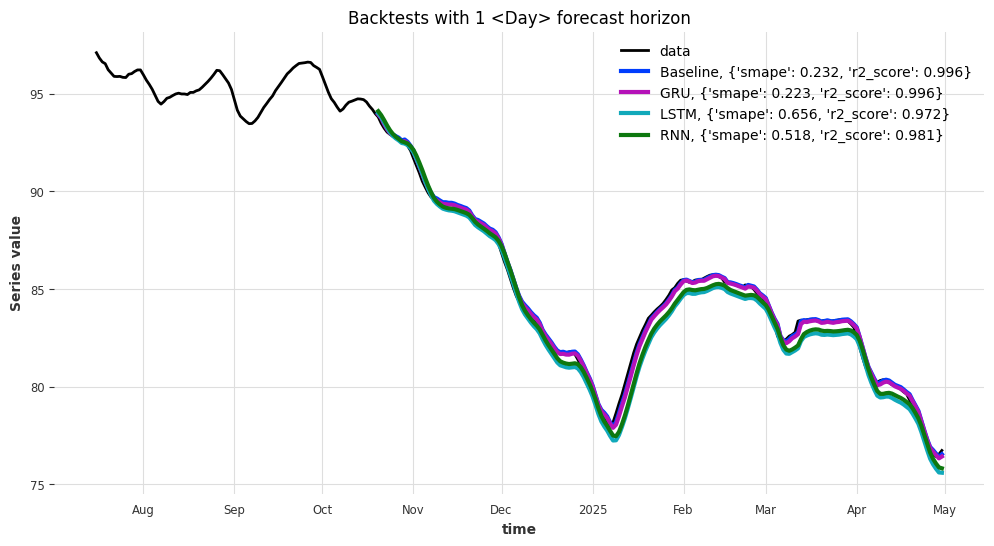

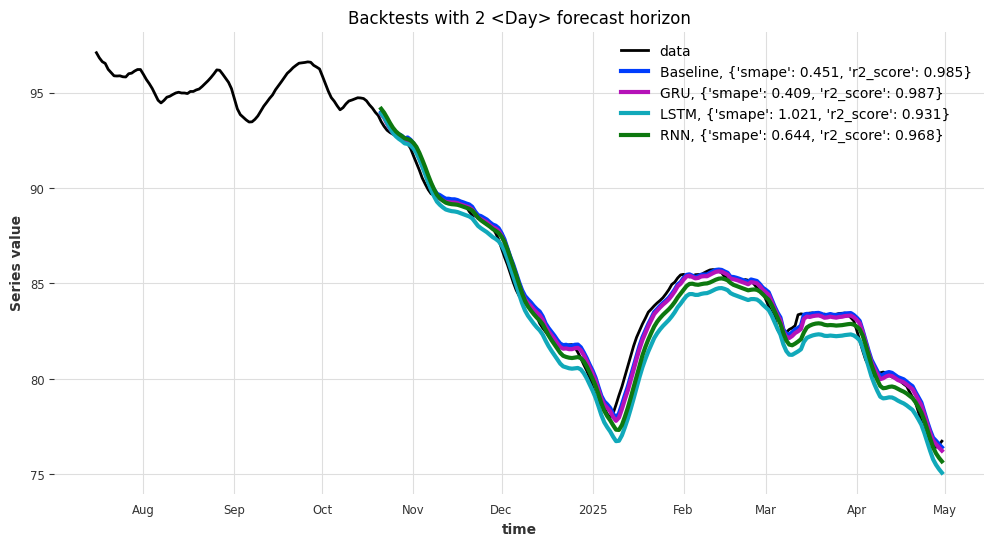

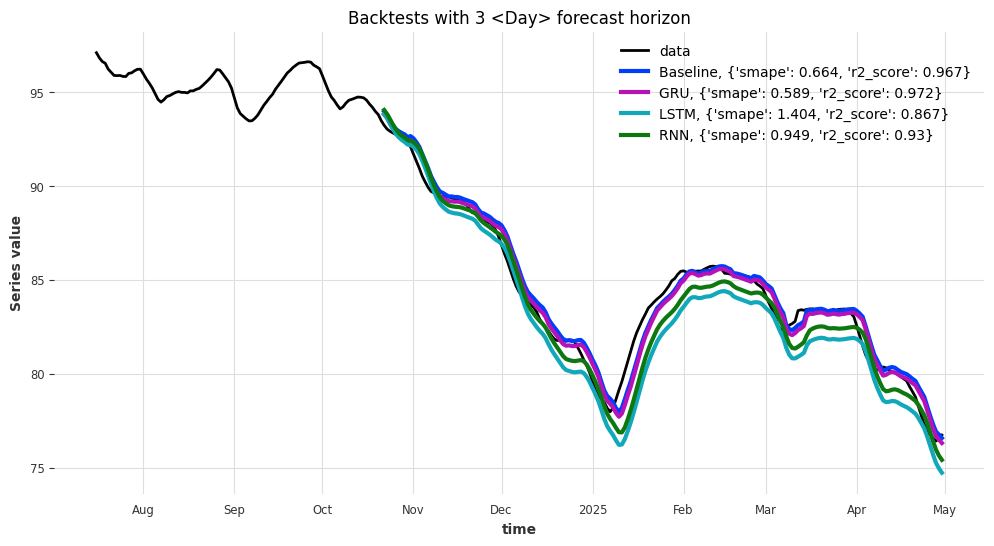

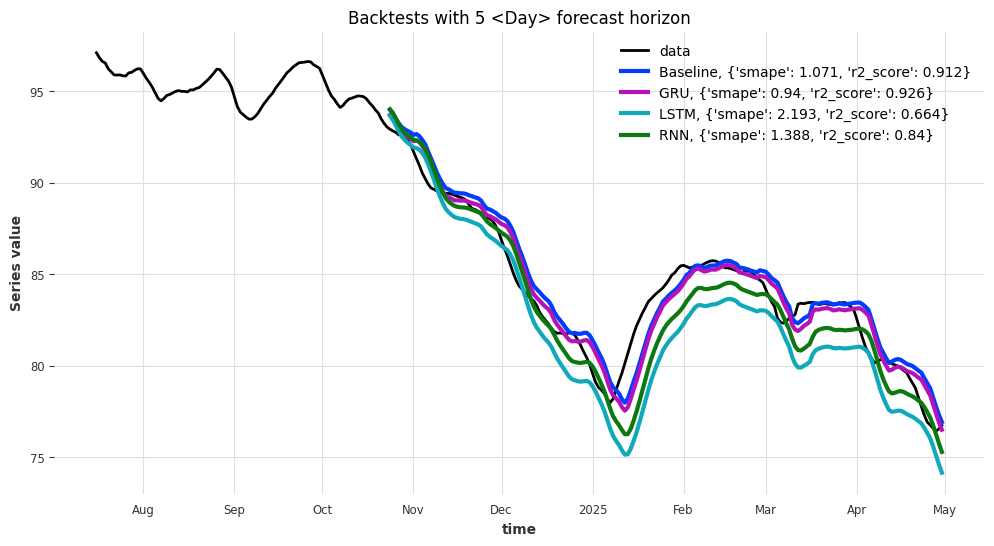

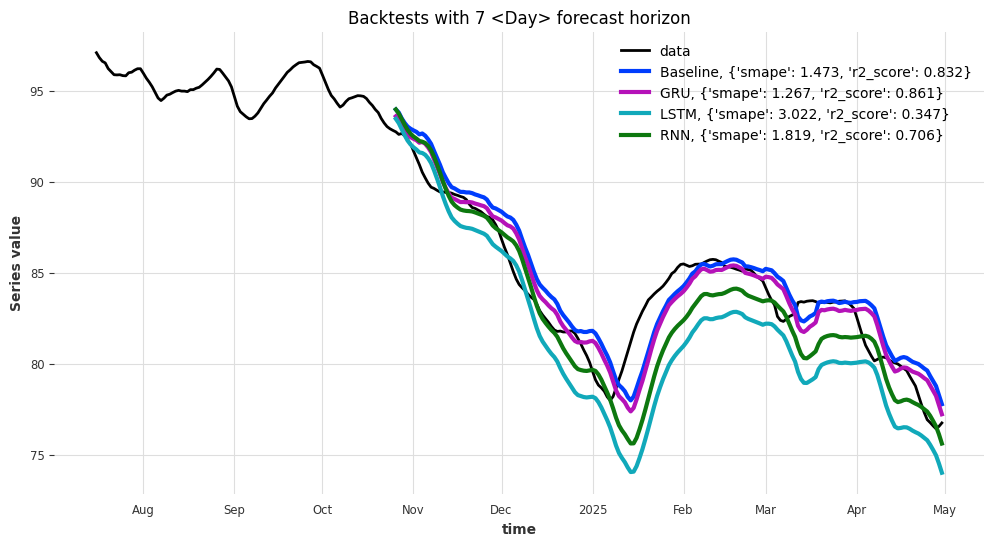

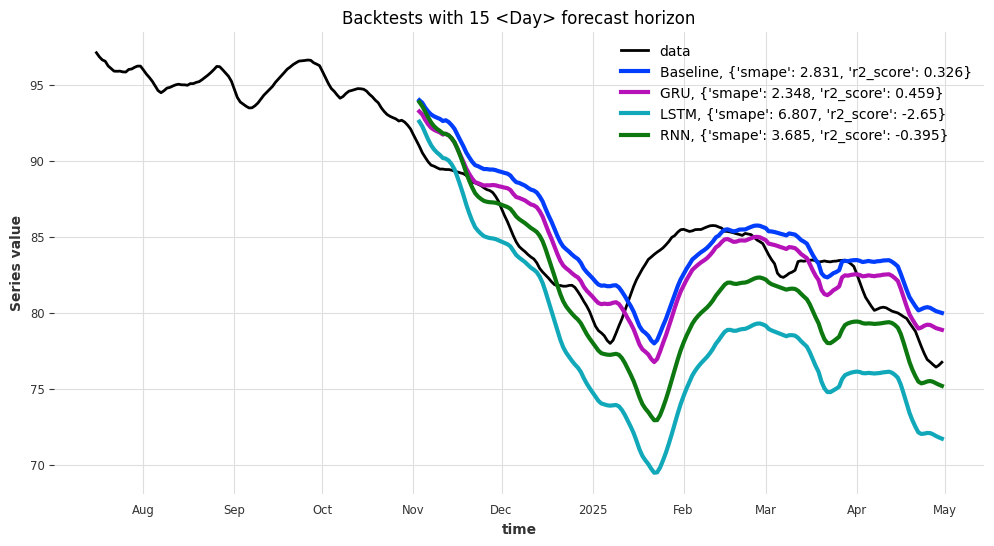

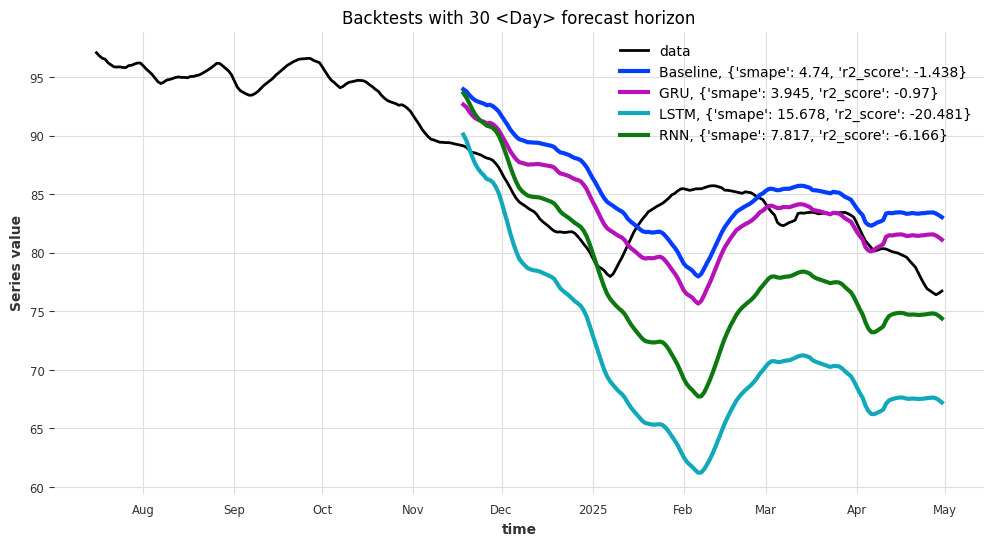

In [92]:
plot_backtest_results(
    series, 
    results, 
    points_to_test=len(test)
)


### Comparação da otimização dos modelos da família RNN

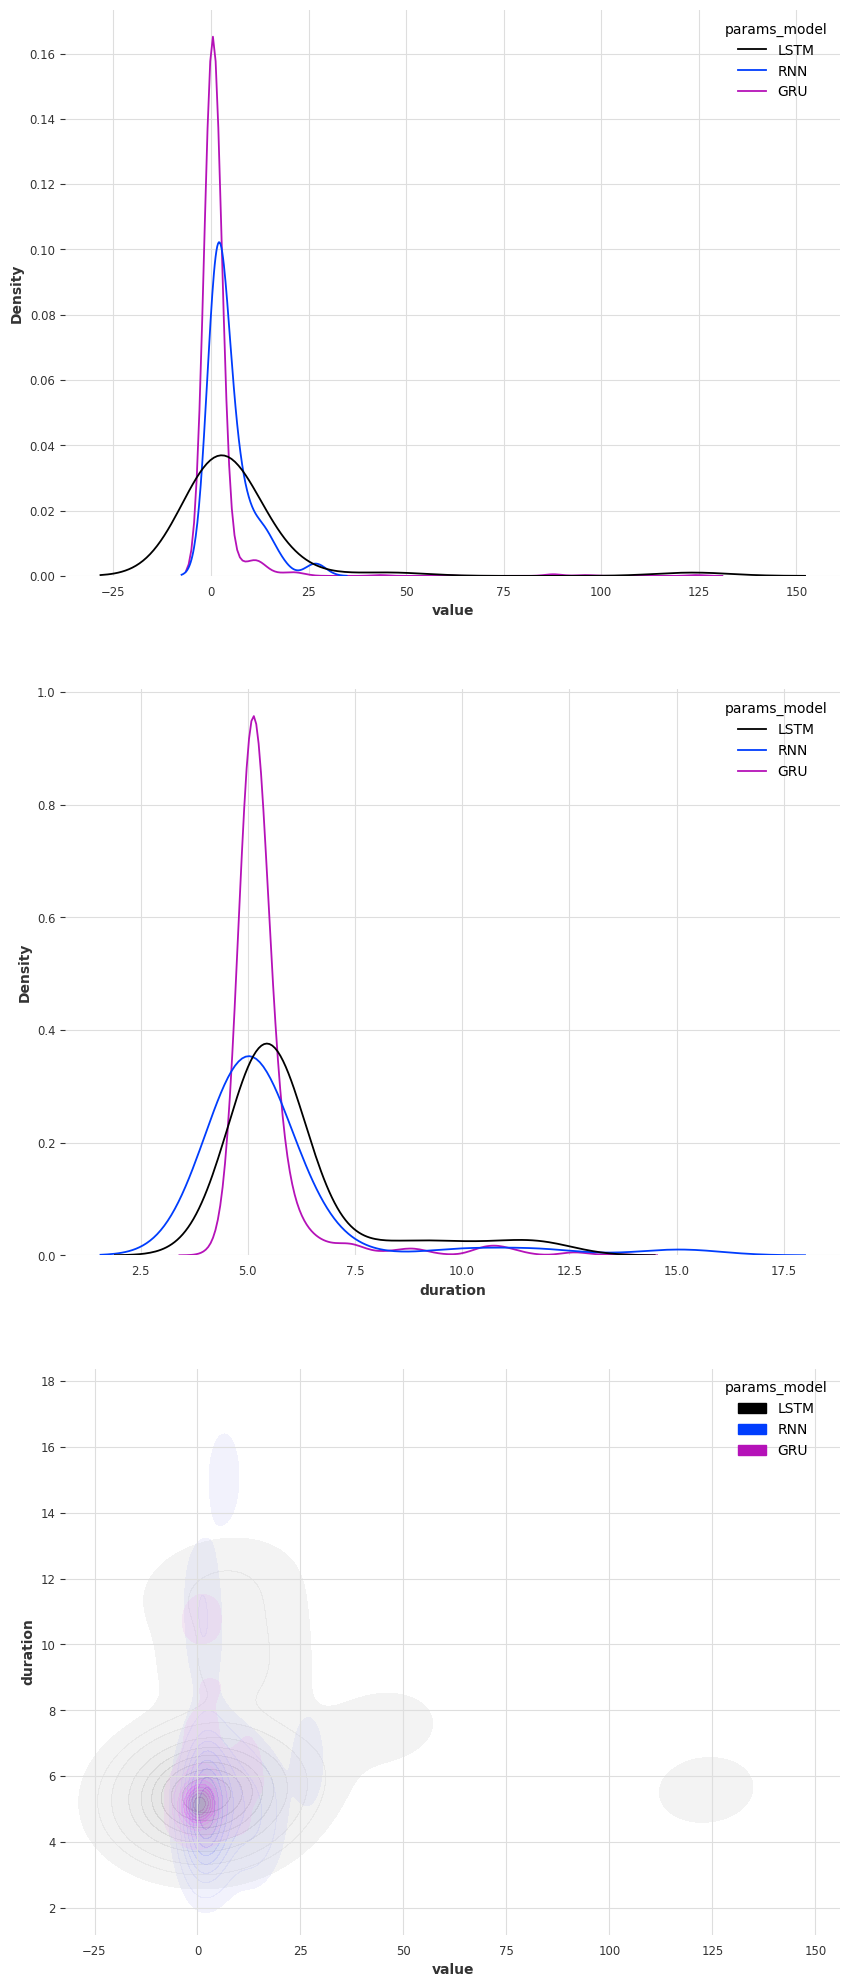

In [62]:
# sns.set(style='dark',)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 25))
sns.kdeplot(study_df, x="value", hue="params_model", ax=ax1, common_norm=False)
sns.kdeplot(study_df, x="duration", hue="params_model", ax=ax2, common_norm=False)
sns.kdeplot(study_df, x="value", y="duration", hue="params_model", ax=ax3, common_norm=False, fill=True, alpha=.2)

plt.show()